# <font color="brown"> Analysis for High-resolution Spectral Data</font>
_<font color="grey">Last updated: 060617</font>_

## <font color="red"> Information about M82</font>
Extracted from our proposal

<img src='https://github.com/Mipanox/PHYS301/blob/master/Project/imgs/M82.png?raw=true' width=90%> </img>

## <font color="blue"> Preparations</font>

In [19]:
%%capture
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/afs/ir.stanford.edu/class/physics100/workdir/g2/Jason/codes/")

import pyfits
import numpy as np
import matplotlib.pyplot as plt
from util import *
from matplotlib.colors import LogNorm
import astropy.units as u
% matplotlib inline

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

_Use the best observations obtained on 060117_

In [16]:
predir  = '/afs/ir.stanford.edu/class/physics100/workdir/g2/final/spectra/'
workdir = '/afs/ir.stanford.edu/class/physics100/workdir/g2/Jason/Project/'
datdir  = predir+'spec_0601/'

### 1. Plate Scale
From the justification [notebook](https://nbviewer.jupyter.org/github/Mipanox/PHYS301/blob/master/Project/SpecAss.ipynb), we know the plate scale:

In [20]:
plate_scale = np.load(workdir+'others/plate_scale.npy') * u.arcsec

### 2. ROI
Define our apertures

In [22]:
M82_data = pyfits.open(datdir+'m82_60min.fit')[0].data
M82_hdr  = pyfits.open(datdir+'m82_60min.fit')[0].header

(170, 300)

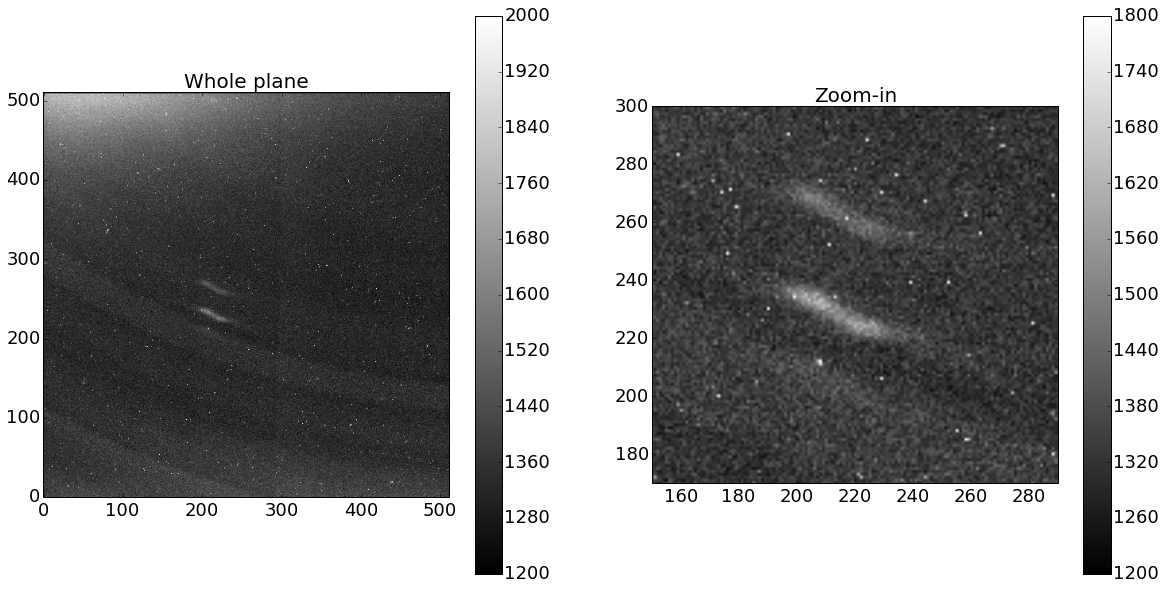

In [47]:
roi_x = np.array((150,290))
roi_y = np.array((170,300))
np.save(workdir+'others/roi_x.npy',roi_x)
np.save(workdir+'others/roi_y.npy',roi_y)

plt.figure(figsize=(20,10))
plt.subplot(121); plt.title('Whole plane')
plt.imshow(M82_data,origin='lower',cmap='gray'); plt.colorbar(); plt.clim(1200,2000)
plt.subplot(122); plt.title('Zoom-in')
plt.imshow(M82_data,origin='lower',cmap='gray'); plt.colorbar(); plt.clim(1200,1800)
plt.xlim(roi_x); plt.ylim(roi_y)

We shall we super optimistic and take this 140 pixels across, which correspond to 

In [42]:
print 'Optimistic diameter = {0:.3f}'.format(140*plate_scale)

Optimistic diameter = 111.138 arcsec


## <font color="blue"> Extracting Spectra</font>

### 1. Wavelength Calibration
_Use the arclamp standard spectrum_<br>
_(Ref: http://www.astrosurf.com/buil/us/spe2/calib2/neon1.gif)_
<img src='http://www.astrosurf.com/buil/us/spe2/calib2/neon1.gif' width=80%> </img>

#### Arc

In [5]:
arc_data = pyfits.open(datdir+'Arc.fit')[0].data
arc_hdr  = pyfits.open(datdir+'Arc.fit')[0].header

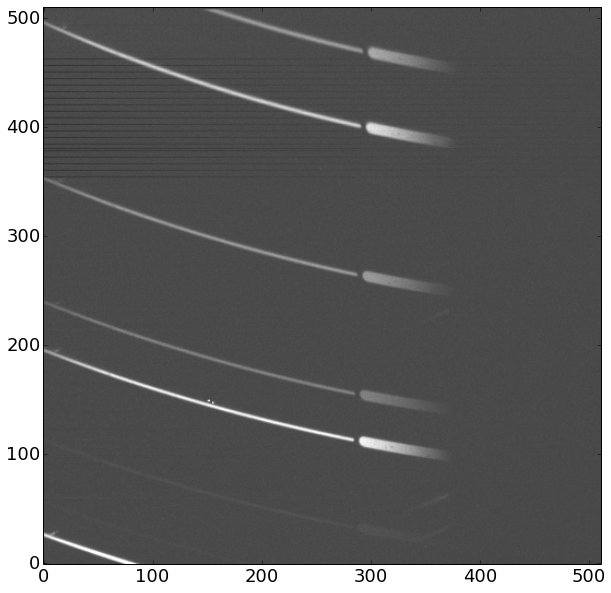

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(arc_data,origin='lower',cmap='gray'); plt.clim(1000,1400)

## <font color="blue"> Analysis - Rotation Curve</font>